# Linear regression approach to water bottom values

Off-shore seismic data acquisition faces many challenges due to difficult environment the ocean can present. The forces from the tugging ship, the presence of waves,  animals, including growth of barnacles, are all factors playing against the arrays of receivers floating on the ocean surface. These factors tend to lead to failures in the recording equipment which can lead to missing data points. Re-processing data of vintage age can also mean that some important data points might be missing.

Here we study the case where the values of the ocean bottom values have missing points in the recorded values. We approach the problem via linear regression, and explore which type of regression gives the most satisfactory answer.

We will see the nearest-neighbor approach gives the best result. The kNN case, being non-parametric, exceeds since the ocean bottom is irregular.

We use open-source data collected over a 23.4km-long track. 

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})


## Import data and manipulate 

In [3]:
raw_data = pd.read_csv('oneGun_oneCable_seismic_data.csv')

In [4]:
raw_data.head(4)

,channel_number,shot_number,geophoneDepth,sourceDepth,geophoneDatum,sourceDatum,WBdepth_sourceLocation,WBdepth_geophoneLocation,sourceX,sourceY,geophoneX,geophoneY,shipSpeed,day,hour,minute,sec,streamerNumber
0,577,1580,10.8,6.0,0.0,0.0,37.8,0.0,522200.2,6617332.3,522170.7,6617404.8,226,265,12,56,22,4
1,578,1580,10.7,6.0,0.0,0.0,37.8,0.0,522200.2,6617332.3,522167.7,6617416.9,226,265,12,56,22,4
2,579,1580,10.6,6.0,0.0,0.0,37.8,0.0,522200.2,6617332.3,522164.6,6617429.1,226,265,12,56,22,4
3,580,1580,10.6,6.0,0.0,0.0,37.8,0.0,522200.2,6617332.3,522161.5,6617441.2,226,265,12,56,22,4


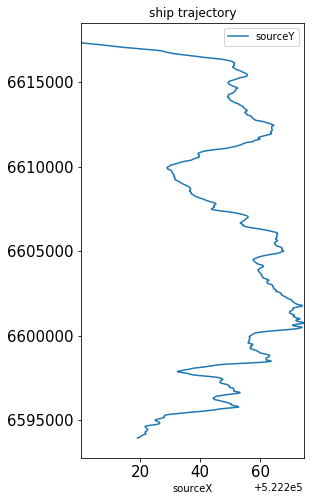

In [5]:
# plotting the traverse of the ship
raw_data.groupby('sourceY').first().reset_index().plot(x='sourceX',y='sourceY',figsize=(4,8),title='ship trajectory',fontsize=15)

Let's transform the hour, minute,second columns to one measure of time.

In [6]:
raw_data['time'] = raw_data['hour']*60*60 + raw_data['minute']*60 + raw_data['sec']

Note that all of the data in raw_data was acquired the same day. Day = 265 for all observations. Also, gdel and sdel columns are constant. So we get rid of these three columns. We can also get rid of the hour, minute, and sec values since we have the column `time`.

In [7]:
#checking that column is indeed constant
raw_data['day'].min() == raw_data['day'].max()

True

In [8]:
raw_data.geophoneDatum.min() == raw_data.geophoneDatum.max()

True

In [9]:
raw_data.sourceDatum.min() == raw_data.sourceDatum.max()

True

We will call our final dataframe "relevant_data":

In [10]:
#dropping irrelevant columns
relevant_data = raw_data.drop(['day','geophoneDatum','sourceDatum','hour','minute','sec'],axis=1).groupby('shot_number').first().reset_index()

In [11]:
relevant_data.head()

,shot_number,channel_number,geophoneDepth,sourceDepth,WBdepth_sourceLocation,WBdepth_geophoneLocation,sourceX,sourceY,geophoneX,geophoneY,shipSpeed,streamerNumber,time
0,1580,577,10.8,6.0,37.8,0.0,522200.2,6617332.3,522170.7,6617404.8,226,4,46582
1,1596,577,10.8,6.1,37.8,0.0,522201.4,6617307.4,522172.0,6617379.9,226,4,46593
2,1612,577,10.8,6.0,37.9,0.0,522202.6,6617282.7,522173.4,6617355.4,214,4,46605
3,1628,577,10.7,6.0,38.0,0.0,522204.0,6617257.2,522175.0,6617330.2,218,4,46616
4,1644,577,10.7,6.1,38.1,0.0,522205.4,6617232.4,522176.8,6617305.4,219,4,46627


In [12]:
relevant_data.columns

Index(['shot_number', 'channel_number', 'geophoneDepth', 'sourceDepth',
       'WBdepth_sourceLocation', 'WBdepth_geophoneLocation', 'sourceX',
       'sourceY', 'geophoneX', 'geophoneY', 'shipSpeed', 'streamerNumber',
       'time'],
      dtype='object')

We get k-folds for cross-validation:

In [13]:
kfolds = KFold(n_splits=10,shuffle=False,random_state=0)

In [14]:
lasso = Lasso(alpha=1,fit_intercept=True,normalize=True,random_state=0)

# Modelling WBdepth_sourceLocation (water bottom depth at source) 

Let's plot the water bottom value as a function of the shot number. The water bottom depth is recorded at the location of each shot (source point).

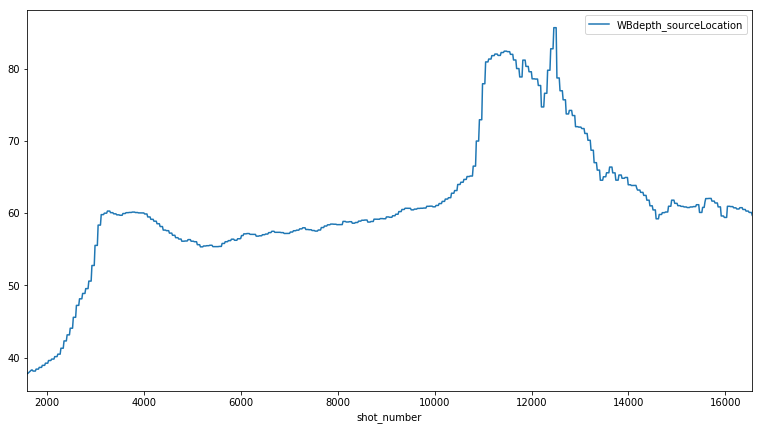

In [15]:
relevant_data.plot(x='shot_number',y='WBdepth_sourceLocation',figsize=(13,7))

In [16]:
# we pick the attributes out of the columns in relevant_data:

waterDepthAttributes = ['shot_number', 'channel_number', 'geophoneDepth', 'sourceDepth', 'WBdepth_geophoneLocation', 'sourceX',
       'sourceY', 'geophoneX', 'geophoneY', 'shipSpeed', 'streamerNumber',
       'time']

Split the data into a testing and training set. The training set will further broken up in cross-validation sets.

In [17]:
W_train,W_test,w_train,w_test = train_test_split(relevant_data[waterDepthAttributes],relevant_data['WBdepth_sourceLocation'],random_state=0)

In [18]:
W_train.head()

,shot_number,channel_number,geophoneDepth,sourceDepth,WBdepth_geophoneLocation,sourceX,sourceY,geophoneX,geophoneY,shipSpeed,streamerNumber,time
240,5420,577,10.5,6.0,0.00,522254.0,6611334.1,522223.2,6611407.5,210,4,49402
270,5900,577,10.4,6.0,0.00,522239.6,6610583.9,522210.7,6610658.1,218,4,49745
747,13532,577,10.2,6.1,65.04,522261.9,6598660.5,522253.6,6598739.9,179,4,55724
838,14988,577,10.1,6.1,61.36,522245.1,6596385.9,522236.2,6596465.4,187,4,56951
39,2204,577,10.9,6.0,0.00,522246.9,6616358.1,522216.9,6616430.6,212,4,47036


In [71]:
alphaScan_rss_w = []

for Alpha in np.logspace(-3,1,10):
    
    temp_rss = []
    for trainIndex, valIndex in kfolds.split(W_train):
        lasso = Lasso(alpha=Alpha,fit_intercept=True,normalize=True,random_state=0).fit(W_train.iloc[trainIndex,:],w_train.iloc[trainIndex])
        y_pred_val = lasso.predict(W_train.iloc[valIndex,:])
        temp_rss.append(((y_pred_val - w_train.iloc[valIndex])**2).sum())
        print('at alpha = ',Alpha)
        print(np.nonzero(lasso.coef_)[0])
    
    alphaScan_rss_w.append(np.mean(temp_rss))

at alpha =  0.001
[0 2 3 4 5 6 7 9]
at alpha =  0.001
[0 2 3 4 5 6 7 9]
at alpha =  0.001
[0 2 3 4 5 6 7 9]
at alpha =  0.001
[0 2 3 4 5 6 7 9]
at alpha =  0.001
[0 2 3 4 5 6 7 9]
at alpha =  0.001
[0 2 3 4 5 6 7 9]
at alpha =  0.001
[0 2 3 4 5 6 7 9]
at alpha =  0.001
[0 2 3 4 5 6 7 9]
at alpha =  0.001
[0 2 3 4 5 6 7 9]
at alpha =  0.001
[0 2 3 4 5 6 7 9]
at alpha =  0.0027825594022071257
[0 2 3 4 5 9]
at alpha =  0.0027825594022071257
[0 2 3 4 5 9]
at alpha =  0.0027825594022071257
[0 2 3 4 5 9]
at alpha =  0.0027825594022071257
[0 2 3 4 5 9]
at alpha =  0.0027825594022071257
[0 2 3 4 5 9]
at alpha =  0.0027825594022071257
[0 2 3 4 5 9]
at alpha =  0.0027825594022071257
[0 2 3 4 5 9]
at alpha =  0.0027825594022071257
[0 2 3 4 5 9]
at alpha =  0.0027825594022071257
[0 2 3 4 5 9]
at alpha =  0.0027825594022071257
[0 2 3 4 5 9]
at alpha =  0.007742636826811269
[2 3 4 5 9]
at alpha =  0.007742636826811269
[0 2 3 4 5 9]
at alpha =  0.007742636826811269
[0 2 3 4 5 9]
at alpha =  0.0077426

In [67]:
if [1]:
    print(1)

1


Text(0.5, 1.0, 'RSS(alpha)')

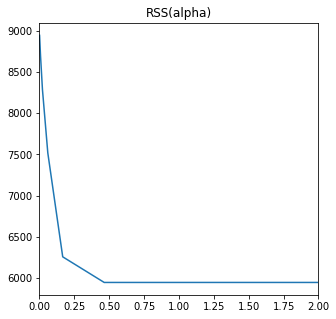

In [63]:
plt.figure(figsize=(5,5))
plt.plot(np.logspace(-3,1,10),alphaScan_rss_w)
plt.xlim(0,2)
plt.title('RSS(alpha)')

We plot the path of the coefficients as we vary alpha:

In [21]:
all_coeffs_w = []
for Alpha in np.logspace(-3,1,20):
    lasso = Lasso(alpha=Alpha, fit_intercept=True, normalize=True, random_state=0).fit(W_train,w_train)
    all_coeffs_w.append(lasso.coef_)

In [22]:
coeff_path_w = np.array(all_coeffs_w).transpose()

Text(0.5, 1.0, 'Coefficient paths')

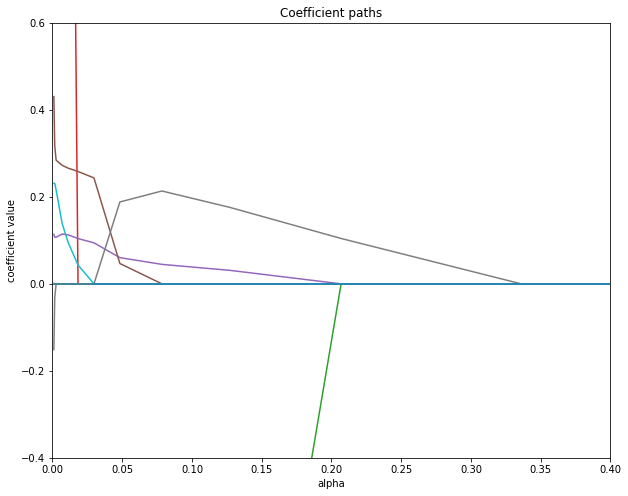

In [23]:
plt.figure(figsize=(10,8))
for x in range(11):
    plt.plot(np.logspace(-3,1,20),coeff_path_w[x])
plt.xlim(0,.4)
plt.ylim(-0.4,.6)
plt.xlabel('alpha')
plt.ylabel('coefficient value')
plt.title('Coefficient paths')

We choose alpha = 0.01.

In [24]:
lasso_w = Lasso(alpha=0.01, fit_intercept=True, normalize=True, random_state=0).fit(W_train,w_train)
w_pred_lasso = lasso_w.predict(W_test)
np.argwhere(lasso_w.coef_ > 0)

array([[3],
       [4],
       [5],
       [9]])

In [25]:
W_train.head(3)

,shot_number,channel_number,geophoneDepth,sourceDepth,WBdepth_geophoneLocation,sourceX,sourceY,geophoneX,geophoneY,shipSpeed,streamerNumber,time
240,5420,577,10.5,6.0,0.00,522254.0,6611334.1,522223.2,6611407.5,210,4,49402
270,5900,577,10.4,6.0,0.00,522239.6,6610583.9,522210.7,6610658.1,218,4,49745
747,13532,577,10.2,6.1,65.04,522261.9,6598660.5,522253.6,6598739.9,179,4,55724


Lasso is selecting the following attributes: 'ep','selev','sx','sfs'. For other values of alpha 'sy' was also selected so we will include it.

In [26]:
#lassoSelectedAttr = ['ep','selev','sx','sy','sfs']
lassoSelectedAttr= ['shot_number',  'sourceDepth', 'WBdepth_geophoneLocation', 'sourceX',
       'sourceY',   'streamerNumber',]

### Ridge regression and linear regression with selected attributes

With the selected attributes, we employ ridge regression on the same data:

In [27]:
W_train_selected = W_train[lassoSelectedAttr]
W_test_selected = W_test[lassoSelectedAttr]

In [28]:
W_test_selected.head()

,shot_number,sourceDepth,WBdepth_geophoneLocation,sourceX,sourceY,streamerNumber
406,8076,6.0,0.00,522253.7,6607184.1,4
14,1804,6.0,0.00,522218.9,6616982.8,4
689,12604,6.1,78.71,522257.8,6600110.7,4
145,3900,5.9,0.00,522252.7,6613709.4,4
310,6540,6.0,0.00,522230.9,6609583.8,4


In [29]:
ridge_w_RSS = []
for Lambda in np.logspace(-4,2):
    
    temp_rss = []
    
    for trainIndex, testIndex in kfolds.split(W_train_selected):
    
        ridge = Ridge(alpha=Lambda, fit_intercept=True, normalize=True,random_state=0).fit(W_train_selected.iloc[trainIndex],w_train.iloc[trainIndex])
        temp_rss.append(((w_train.iloc[testIndex] - ridge.predict(W_train_selected.iloc[testIndex]))**2 ).sum())
    
    ridge_w_RSS.append(np.mean(temp_rss))
    

Text(0.5, 1.0, 'RSS(lambda)')

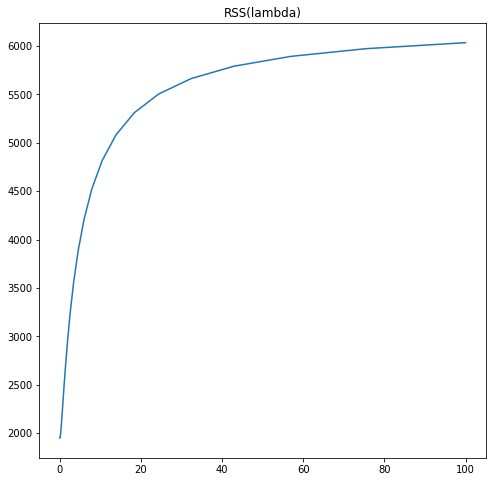

In [30]:
plt.figure(figsize=(8,8))
plt.plot(np.logspace(-4,2),ridge_w_RSS)
plt.title('RSS(lambda)')

Let's look at the path of the coefficients

In [31]:
ridge_coeff = []
for Lambda in np.logspace(-4,2):
    ridge =  Ridge(alpha=Lambda, fit_intercept=True, normalize=True,random_state=0).fit(W_train_selected.iloc[trainIndex],w_train.iloc[trainIndex])
    ridge_coeff.append(ridge.coef_)

In [32]:
ridge_coeff_path = np.array(ridge_coeff).transpose()

Text(0, 0.5, 'coefficient value')

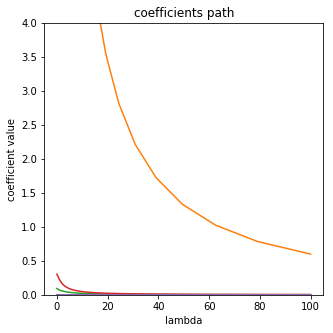

In [33]:
plt.figure(figsize=(5,5))
for x in range(5):
    plt.plot(np.logspace(-3,2),ridge_coeff_path[x])
plt.ylim(0,4)
plt.title('coefficients path')
plt.xlabel('lambda')
plt.ylabel('coefficient value')

Zooming in:

(0, 0.02)

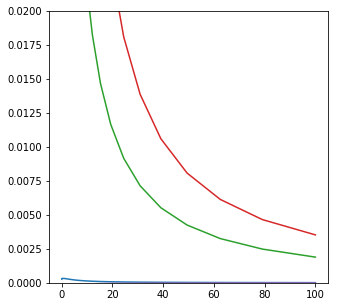

In [34]:
plt.figure(figsize=(5,5))
for x in range(5):
    plt.plot(np.logspace(-3,2),ridge_coeff_path[x])
plt.ylim(0,.02)

We can see from the above plots that the values of the linear regression coefficients are never too big, even at the lowest values of Lambda. Therefore there is not a lot of overfitting. Therefore we can move forward to model using Ridge regression using the smallest Lambda:

In [35]:
ridge_w = Ridge(alpha=.0001, fit_intercept=True, normalize=True,random_state=0).fit(W_train_selected,w_train)

In [36]:
w_pred_ridge = ridge_w.predict(W_test_selected)

Train and predict using non-regularized linear regression on the selected features:

In [37]:
lr_w = LinearRegression(fit_intercept=True, normalize=True).fit(W_train_selected,w_train)

In [38]:
w_pred_lr = lr_w.predict(W_test_selected)

### Let's plot the predictions for each model

We start by making a dataframe so that we can line up the results:

In [39]:
W_results = W_test_selected.copy()

In [40]:
W_results['w_pred_lr'] = w_pred_lr
W_results['w_pred_ridge']= w_pred_ridge
W_results['w_pred_lasso'] = w_pred_lasso
W_results['WBdepth_sourceLocation'] = w_test

Note that there is degeneracy:

In [41]:
W_results.sort_values(by='sourceX').head(5)

,shot_number,sourceDepth,WBdepth_geophoneLocation,sourceX,sourceY,streamerNumber,w_pred_lr,w_pred_ridge,w_pred_lasso,WBdepth_sourceLocation
1,1596,6.1,0.0,522201.4,6617307.4,4,39.913716,39.030187,40.670463,37.80
2,1612,6.0,0.0,522202.6,6617282.7,4,38.964224,38.309256,39.445723,37.90
5,1660,5.9,0.0,522206.9,6617207.4,4,39.662801,38.556203,44.532381,38.20
8,1708,6.1,0.0,522210.8,6617132.5,4,42.767556,41.973870,46.163568,38.15
14,1804,6.0,0.0,522218.9,6616982.8,4,43.993548,43.412375,47.305149,38.42


#### To plot keyed off sx:

In [42]:
W_results_x = W_results.groupby(by='sourceX').first().reset_index()

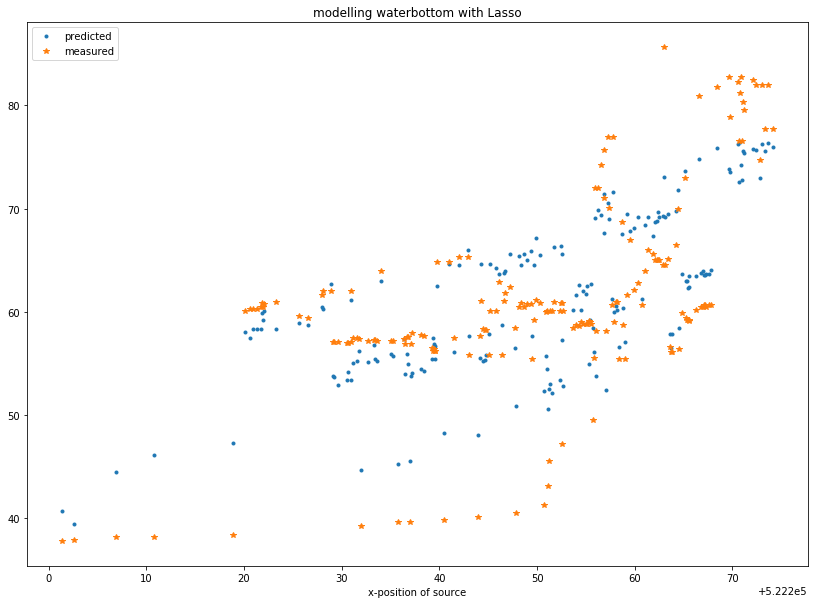

In [43]:
plt.figure(figsize=(14,10))
plt.plot(W_results_x.sourceX,W_results_x.w_pred_lasso,'o',markersize=3)
#plt.plot(W_results_sx.sx,W_results_sx.w_pred_lr,'o', markersize=3)
#plt.plot(W_results_sx.sx,W_results_sx.w_pred_ridge,'o',markersize=3)
plt.plot(W_results_x.sourceX,W_results_x.WBdepth_sourceLocation,'*')
plt.title('modelling waterbottom with Lasso')
plt.xlabel('x-position of source')
plt.legend(['predicted','measured'],loc='upper left')

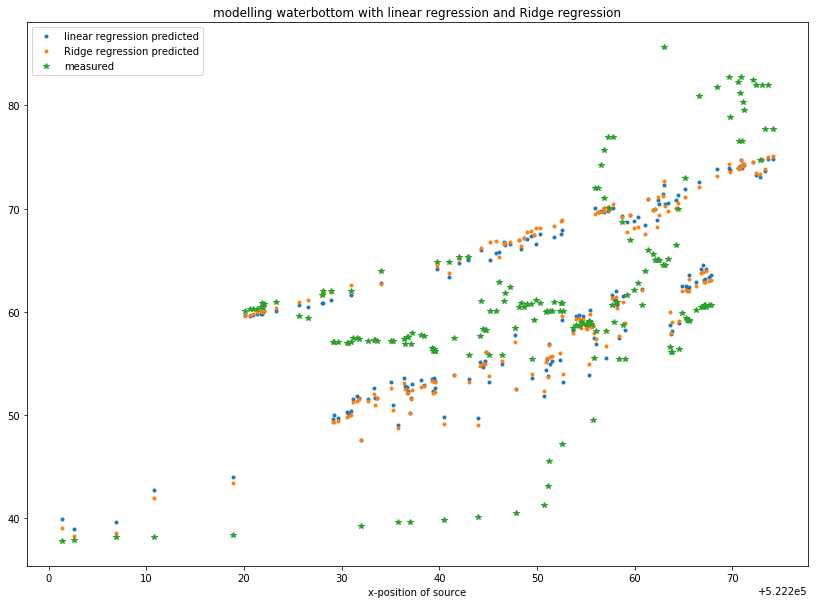

In [44]:
plt.figure(figsize=(14,10))
plt.plot(W_results_x.sourceX,W_results_x.w_pred_lr,'o', markersize=3)
plt.plot(W_results_x.sourceX,W_results_x.w_pred_ridge,'o',markersize=3)
plt.plot(W_results_x.sourceX,W_results_x.WBdepth_sourceLocation,'*')
plt.title('modelling waterbottom with linear regression and Ridge regression')
plt.xlabel('x-position of source')
plt.legend(['linear regression predicted','Ridge regression predicted','measured'],loc='upper left')

#### To plot keyed off sy

In [45]:
W_results_y = W_results.groupby(by='sourceY').first().reset_index()

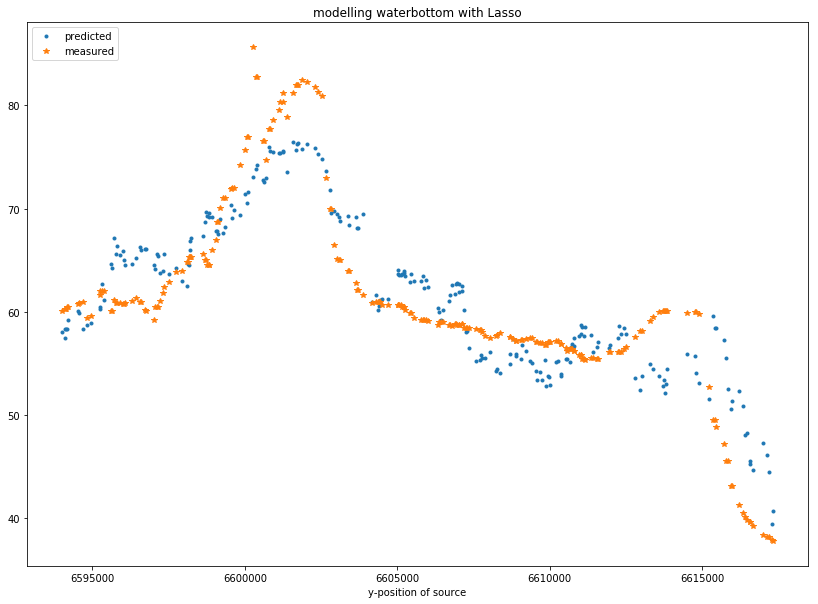

In [46]:
plt.figure(figsize=(14,10))
plt.plot(W_results_y.sourceY,W_results_y.w_pred_lasso,'o',markersize=3)
#plt.plot(W_results_sx.sx,W_results_sx.w_pred_lr,'o', markersize=3)
#plt.plot(W_results_sx.sx,W_results_sx.w_pred_ridge,'o',markersize=3)
plt.plot(W_results_y.sourceY,W_results_y.WBdepth_sourceLocation,'*')
plt.title('modelling waterbottom with Lasso')
plt.xlabel('y-position of source')
plt.legend(['predicted','measured'],loc='upper left')

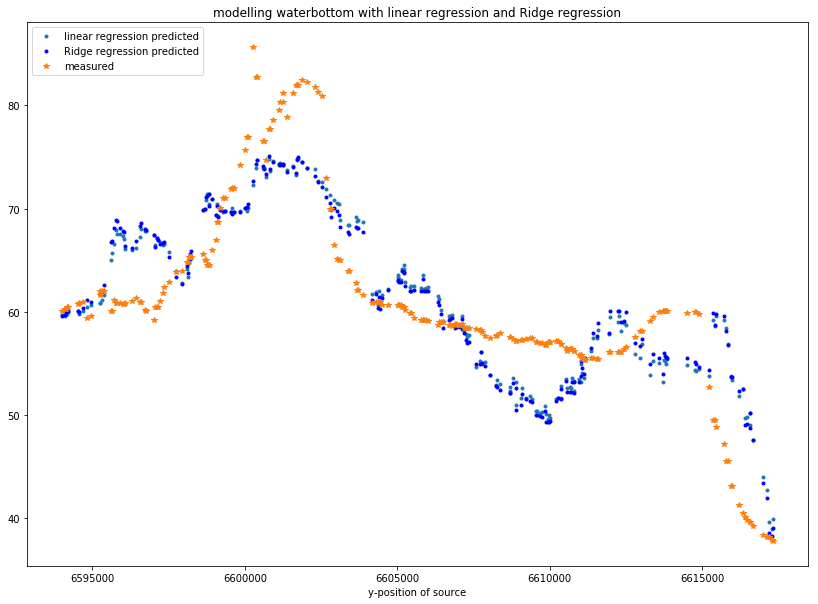

In [47]:
plt.figure(figsize=(14,10))
plt.plot(W_results_y.sourceY,W_results_y.w_pred_lr,'o', markersize=3)
plt.plot(W_results_y.sourceY,W_results_y.w_pred_ridge,'ob',markersize=3)
plt.plot(W_results_y.sourceY,W_results_y.WBdepth_sourceLocation,'*')
plt.title('modelling waterbottom with linear regression and Ridge regression')
plt.xlabel('y-position of source')
plt.legend(['linear regression predicted','Ridge regression predicted','measured'],loc='upper left')

#### To plot data key off shot number

In [48]:
W_results_shot = W_results.groupby('shot_number').first().reset_index()

In [49]:
W_results_shot.head()

,shot_number,sourceDepth,WBdepth_geophoneLocation,sourceX,sourceY,streamerNumber,w_pred_lr,w_pred_ridge,w_pred_lasso,WBdepth_sourceLocation
0,1596,6.1,0.0,522201.4,6617307.4,4,39.913716,39.030187,40.670463,37.80
1,1612,6.0,0.0,522202.6,6617282.7,4,38.964224,38.309256,39.445723,37.90
2,1660,5.9,0.0,522206.9,6617207.4,4,39.662801,38.556203,44.532381,38.20
3,1708,6.1,0.0,522210.8,6617132.5,4,42.767556,41.973870,46.163568,38.15
4,1804,6.0,0.0,522218.9,6616982.8,4,43.993548,43.412375,47.305149,38.42


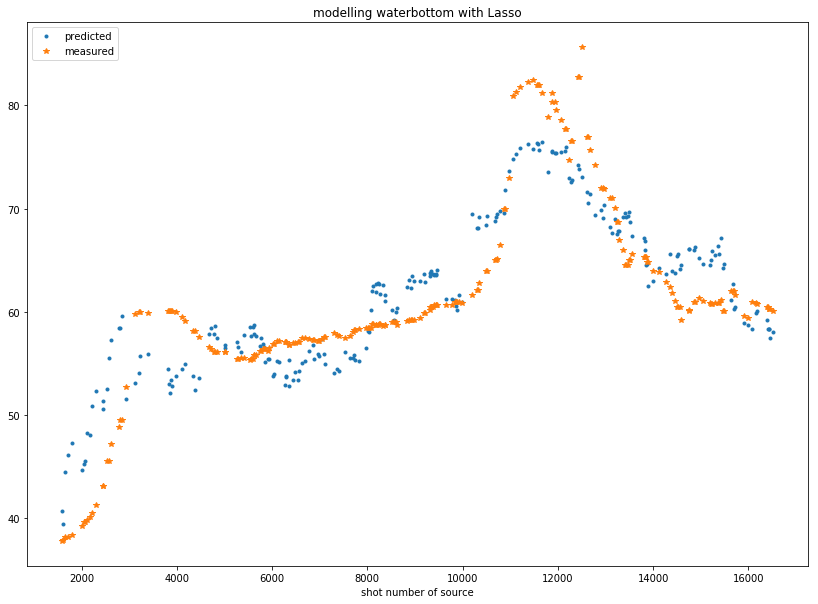

In [50]:
plt.figure(figsize=(14,10))
plt.plot(W_results_shot.shot_number,W_results_shot.w_pred_lasso,'o',markersize=3)
#plt.plot(W_results_sx.sx,W_results_sx.w_pred_lr,'o', markersize=3)
#plt.plot(W_results_sx.sx,W_results_sx.w_pred_ridge,'o',markersize=3)
plt.plot(W_results_shot.shot_number,W_results_shot.WBdepth_sourceLocation,'*')
plt.title('modelling waterbottom with Lasso')
plt.xlabel('shot number of source')

plt.legend(['predicted','measured'],loc='upper left')

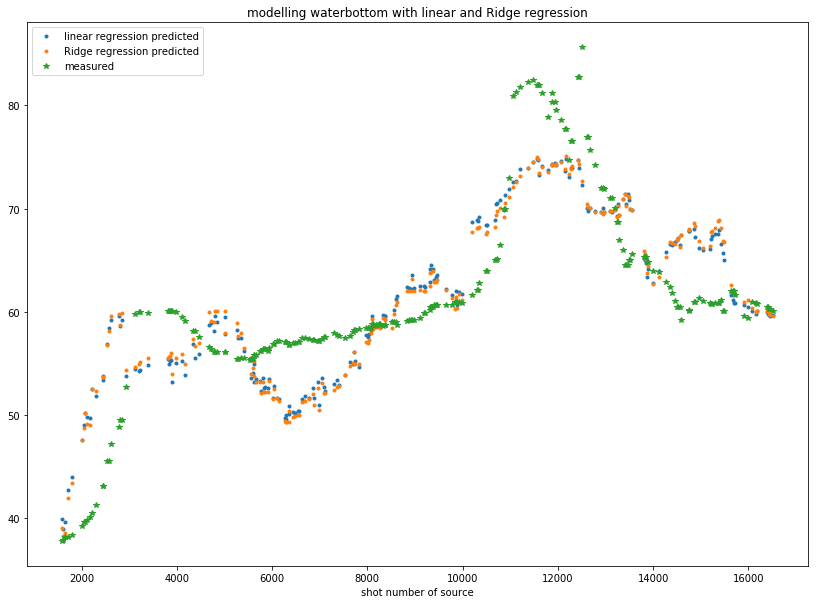

In [51]:

plt.figure(figsize=(14,10))
plt.plot(W_results_shot.shot_number,W_results_shot.w_pred_lr,'o', markersize=3)
plt.plot(W_results_shot.shot_number,W_results_shot.w_pred_ridge,'o',markersize=3)
plt.plot(W_results_shot.shot_number,W_results_shot.WBdepth_sourceLocation,'*')
plt.title('modelling waterbottom with linear and Ridge regression')
plt.xlabel('shot number of source')
plt.legend(['linear regression predicted','Ridge regression predicted','measured'],loc='upper left')


## Using kNN linear regression

We start by cross-validation to seek for the appropriate k. Given how irregular the ocean bottom, we expect this approach to give the best predictions.

In [52]:
knn_rss = []
for k in range(1,100,4):
    
    temp_rss = []
    
    for trainIndex, testIndex in kfolds.split(W_train_selected):
    
        knn_model = KNeighborsRegressor(n_neighbors=k,weights='distance').fit(W_train_selected.iloc[trainIndex],w_train.iloc[trainIndex])
        temp_rss.append(((w_train.iloc[testIndex] - knn_model.predict(W_train_selected.iloc[testIndex]))**2 ).sum())
    
    knn_rss.append(np.mean(temp_rss))

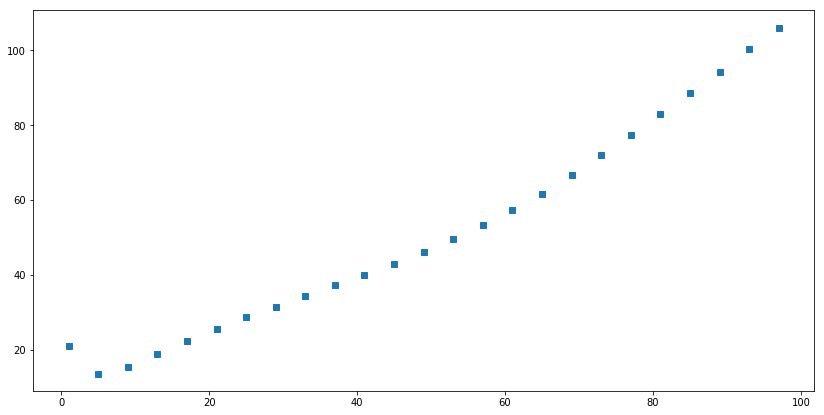

In [53]:
plt.figure(figsize=(14,7))
plt.plot(list(range(1,100,4)),knn_rss,'s')

In [54]:
knn_model_2 = KNeighborsRegressor(n_neighbors=2,weights='distance').fit(W_train_selected,w_train)
y_pred_knn2 = knn_model_2.predict(W_test_selected)

In [55]:
W_results_knn = W_test_selected.copy()
W_results_knn['WBdepth_sourceLocation']=w_test
W_results_knn['y_pred_knn2']= y_pred_knn2

In [56]:
W_results_knn = W_results_knn.groupby('shot_number').first().reset_index()
W_results_knn.head()

,shot_number,sourceDepth,WBdepth_geophoneLocation,sourceX,sourceY,streamerNumber,WBdepth_sourceLocation,y_pred_knn2
0,1596,6.1,0.0,522201.4,6617307.4,4,37.80,37.866409
1,1612,6.0,0.0,522202.6,6617282.7,4,37.90,37.932438
2,1660,5.9,0.0,522206.9,6617207.4,4,38.20,38.200293
3,1708,6.1,0.0,522210.8,6617132.5,4,38.15,38.224777
4,1804,6.0,0.0,522218.9,6616982.8,4,38.42,38.420000


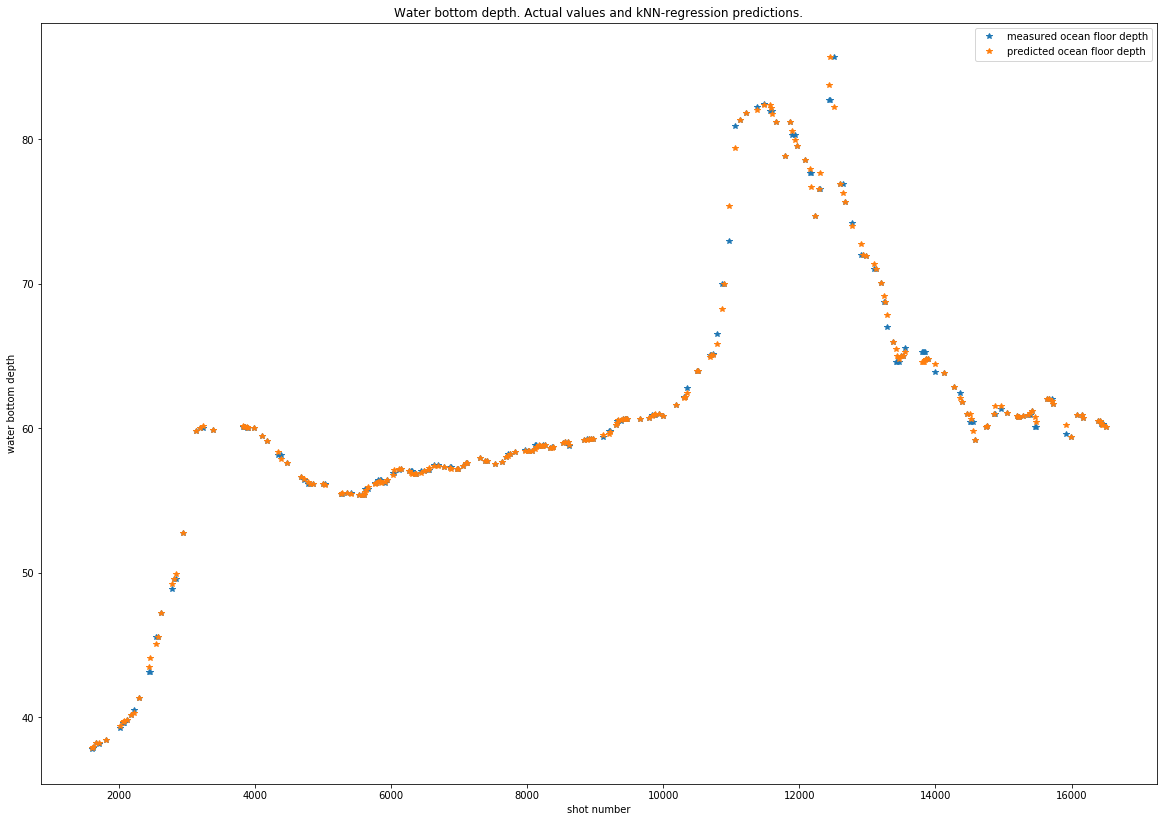

In [58]:
plt.figure(figsize=(20,14))
plt.plot(W_results_knn.shot_number,W_results_knn.WBdepth_sourceLocation,"*")
plt.plot(W_results_knn.shot_number,W_results_knn.y_pred_knn2,'*')
plt.xlabel('shot number')
plt.ylabel('water bottom depth')
plt.title('Water bottom depth. Actual values and kNN-regression predictions.')
plt.legend(['measured ocean floor depth', 'predicted ocean floor depth'])